In [ ]:
!git clone https://github.com/montemac/algebraic_value_editing.git
!cd algebraic_value_editing && pip install -e .

Cloning into 'algebraic_value_editing'...
remote: Enumerating objects: 2121, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 2121 (delta 242), reused 238 (delta 219), pack-reused 1850
Receiving objects: 100% (2121/2121), 12.87 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (1503/1503), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/algebraic_value_editing
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/neelnanda-io/TransformerLens (to revision 9e034eef796ed32b0e473ca9f3c9d31e5d5046e7) to /tmp/pip-install-enhzdpu8/transformer-lens_1c16c8acabe641019e1302aa3202fe5a
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-install-enhzdpu8/transformer-lens_1c16c8acabe641019e1302aa3202fe5a
  Running command git rev-parse -q --verify 'sha^9e034eef796ed32b0e473ca9f3c

In [ ]:
import sys
sys.path.insert(0,"/content/algebraic_value_editing")

In [ ]:
# commit = "c26f254" # Stable commit
# get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/montemac/algebraic_value_editing.git')

In [ ]:
# rich_prompts = [*get_x_vector_preset(prompt1="Love",
#                                      prompt2="Hate",
#                                      coeff=5, act_name=6)]

# print_n_comparisons(prompt="I hate you because",
#                     tokens_to_generate=80,
#                     rich_prompts=rich_prompts,
#                     num_comparisons=15,
#                     seed=0,
#                     **default_kwargs)

In [ ]:
# !pip install tuned-lens

In [ ]:
# from algebraic_value_editing.prompt_utils import RichPrompt, get_x_vector

In [ ]:
# import sys; import pprint
# print(sys.path)

In [ ]:
# import sys
# sys.path.insert(0,"/content/algebraic_value_editing")

In [ ]:
from typing import List, Dict, Callable, Literal
from transformer_lens.HookedTransformer import HookedTransformer

from tuned_lens import TunedLens
from tuned_lens.plotting import PredictionTrajectory
import numpy as np
import torch

from algebraic_value_editing import completion_utils, utils
from algebraic_value_editing.prompt_utils import get_x_vector
from algebraic_value_editing.lenses import run_hooked_and_normal_with_cache, prediction_trajectories
import algebraic_value_editing.hook_utils as hook_utils
from plotly.subplots import make_subplots
from transformers import AutoModelForCausalLM

from transformer_lens.utils import to_numpy
from einops import rearrange
import matplotlib.pyplot as plt

import torch
import pandas as pd

import joblib


In [ ]:
model_name = "gpt2-xl"

device = "cuda"

torch.set_grad_enabled(False)

# Load model from huggingface
# TODO: Fix memory waste from loading model twice
hf_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # revision=f"checkpoint-{cfg.checkpoint_value}"
)

model: HookedTransformer = HookedTransformer.from_pretrained(
    model_name=model_name,
    hf_model=hf_model,
    device="cpu",
).to(device)
model.cfg.device = device
model.eval()

# %%

# NOTE: Hash mismatch on latest tuned lens. Seems fine to ignore, see issue:
# https://github.com/AlignmentResearch/tuned-lens/issues/89
tuned_lens = TunedLens.from_model_and_pretrained(
    hf_model, lens_resource_id=model_name
).to(device)

# %%
# Library helpers

Metric = Literal["entropy", "forward_kl", "max_probability"]


def apply_metric(metric: Metric, pt: PredictionTrajectory):
    return getattr(pt, metric)()


def plot_lens_diff(
    caches: List[Dict[str, torch.Tensor]],
    dataframes: List[pd.DataFrame],
    metric: Metric,
    layer_stride: int = 4,
):
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.03,
        # subplot_titles=("Entropy", "Forward KL", "Cross Entropy", "Max Probability"),
    )

    fig.update_layout(
        height=1000,
        width=800,
        title_text="Tokens visualized with the Tuned Lens",
    )

    trajectories = prediction_trajectories(
        caches, dataframes, model.tokenizer, tuned_lens
    )

    # Update heatmap data inside playground function
    hm_normal = apply_metric(metric, trajectories[0]).heatmap(
        layer_stride=layer_stride
    )
    hm_modified = apply_metric(metric, trajectories[1]).heatmap(
        layer_stride=layer_stride
    )

    fig.add_trace(hm_normal, row=1, col=1)
    fig.add_trace(hm_modified, row=2, col=1)
    return fig


# Main playground for lenses. Run with ctrl+enter

prompt = "To see the eiffel tower, people flock to"

activation_additions = [
    *get_x_vector(
        prompt1="The Eiffel Tower is in Rome",
        prompt2="The Eiffel Tower is in France",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [ ]:
def fwd_hooks_from_activ_hooks(activ_hooks):
    """
    Because AVE data structures differ from transformerlens we must convert.
    >>> fwd_hooks_from_activ_hooks({'blocks.47.hook_resid_pre': ['e1', 'e2']]})
    [('blocks.47.hook_resid_pre', 'e1'), ('blocks.47.hook_resid_pre', 'e2')]
    """
    return [
        (name, hook_fn)
        for name, hook_fns in activ_hooks.items()
        for hook_fn in hook_fns
    ]

def run_hooked_and_normal_with_cache_mlp(
    model, activation_additions, gen_args, device=None
):
    """
    Run hooked and normal with cache.

    Args:
        model: The model to run.
        activation_additions: A list of ActivationAdditions.
        gen_args: Keyword arguments to pass to `completion_utils.gen_using_model`.
            Must include `prompt_batch` and `tokens_to_generate`.

    Returns:
        normal_and_modified_df: A list of two dataframes, one for normal and one for modified.
        normal_and_modified_cache: A list of two caches, one for normal and one for modified.
    """
    assert (
        len(gen_args.get("prompt_batch", [])) == 1
    ), f'Only one prompt is supported. Got {len(gen_args.get("prompt_batch", []))}'

    activ_hooks = hook_utils.hook_fns_from_activation_additions(
        model, activation_additions
    )
    fwd_hooks = fwd_hooks_from_activ_hooks(activ_hooks)
    normal_and_modified_df = []
    normal_and_modified_cache = []

    for fwd_hooks, is_modified in [([], False), (fwd_hooks, True)]:
        cache, caching_hooks, _ = model.get_caching_hooks(
            names_filter=lambda n: "mlp.hook_post" in n, device=device
        )

        # IMPORTANT: We call caching hooks *after* the value editing hooks.
        with model.hooks(fwd_hooks=fwd_hooks + caching_hooks):
            results_df = completion_utils.gen_using_model(
                model, include_logits=True, **gen_args
            )
            results_df["is_modified"] = is_modified
        normal_and_modified_df.append(results_df)
        normal_and_modified_cache.append(cache)

    return normal_and_modified_df, normal_and_modified_cache

In [ ]:
dataframes, caches = run_hooked_and_normal_with_cache(
    model=model,
    activation_additions=activation_additions,
    gen_args=dict(
        prompt_batch=[prompt] * 1, tokens_to_generate=30, top_p=0.3, seed=0
    ),
)

trajectories = prediction_trajectories(
    caches, dataframes, model.tokenizer, tuned_lens
)

fig = plot_lens_diff(
    caches=caches,
    dataframes=dataframes,
    metric="entropy",
    layer_stride=2,
)
fig.show()

# %%
# Play with printing completions to check behavior


completion_utils.print_n_comparisons(
    prompt=prompt,
    num_comparisons=5,
    model=model,
    activation_additions=activation_additions,
    seed=0,
    temperature=1.0,
    freq_penalty=1.0,
    top_p=0.3,
    tokens_to_generate=50,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      To see the eiffel tower, people flock to the Place      |         To see the eiffel tower, people flock to the         |
| de la Concorde in Paris. The tower is so famous that it has  |  Vatican. To see a giant bell, they turn to New York City.   |
|                   its own Wikipedia page.                    |                                                              |
|                                                              |       Rome's grandiose building is known for its many        |
|    The eiffel tower is a tall structure located in Paris,    |     architectural marvels and has been 

In [ ]:
caches[0].keys()

dict_keys(['blocks.0.hook_resid_pre', 'blocks.1.hook_resid_pre', 'blocks.2.hook_resid_pre', 'blocks.3.hook_resid_pre', 'blocks.4.hook_resid_pre', 'blocks.5.hook_resid_pre', 'blocks.6.hook_resid_pre', 'blocks.7.hook_resid_pre', 'blocks.8.hook_resid_pre', 'blocks.9.hook_resid_pre', 'blocks.10.hook_resid_pre', 'blocks.11.hook_resid_pre', 'blocks.12.hook_resid_pre', 'blocks.13.hook_resid_pre', 'blocks.14.hook_resid_pre', 'blocks.15.hook_resid_pre', 'blocks.16.hook_resid_pre', 'blocks.17.hook_resid_pre', 'blocks.18.hook_resid_pre', 'blocks.19.hook_resid_pre', 'blocks.20.hook_resid_pre', 'blocks.21.hook_resid_pre', 'blocks.22.hook_resid_pre', 'blocks.23.hook_resid_pre', 'blocks.24.hook_resid_pre', 'blocks.25.hook_resid_pre', 'blocks.26.hook_resid_pre', 'blocks.27.hook_resid_pre', 'blocks.28.hook_resid_pre', 'blocks.29.hook_resid_pre', 'blocks.30.hook_resid_pre', 'blocks.31.hook_resid_pre', 'blocks.32.hook_resid_pre', 'blocks.33.hook_resid_pre', 'blocks.34.hook_resid_pre', 'blocks.35.hook_res

In [ ]:
caches[0]['blocks.27.hook_resid_pre'].shape

torch.Size([1, 42, 1600])

In [ ]:
dataframes, caches = run_hooked_and_normal_with_cache_mlp(
    model=model,
    activation_additions=activation_additions,
    gen_args=dict(
        prompt_batch=[prompt] * 1, tokens_to_generate=30, top_p=0.3, seed=0
    ),
)

trajectories = prediction_trajectories(
    caches, dataframes, model.tokenizer, tuned_lens
)

fig = plot_lens_diff(
    caches=caches,
    dataframes=dataframes,
    metric="entropy",
    layer_stride=2,
)
fig.show()

# %%
# Play with printing completions to check behavior


completion_utils.print_n_comparisons(
    prompt=prompt,
    num_comparisons=5,
    model=model,
    activation_additions=activation_additions,
    seed=0,
    temperature=1.0,
    freq_penalty=1.0,
    top_p=0.3,
    tokens_to_generate=50,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      To see the eiffel tower, people flock to the Place      |         To see the eiffel tower, people flock to the         |
| de la Concorde in Paris. The tower is so famous that it has  |  Vatican. To see a giant bell, they turn to New York City.   |
|                   its own Wikipedia page.                    |                                                              |
|                                                              |       Rome's grandiose building is known for its many        |
|    The eiffel tower is a tall structure located in Paris,    |     architectural marvels and has been 

In [ ]:
caches[0].keys()

dict_keys(['blocks.0.mlp.hook_post', 'blocks.1.mlp.hook_post', 'blocks.2.mlp.hook_post', 'blocks.3.mlp.hook_post', 'blocks.4.mlp.hook_post', 'blocks.5.mlp.hook_post', 'blocks.6.mlp.hook_post', 'blocks.7.mlp.hook_post', 'blocks.8.mlp.hook_post', 'blocks.9.mlp.hook_post', 'blocks.10.mlp.hook_post', 'blocks.11.mlp.hook_post', 'blocks.12.mlp.hook_post', 'blocks.13.mlp.hook_post', 'blocks.14.mlp.hook_post', 'blocks.15.mlp.hook_post', 'blocks.16.mlp.hook_post', 'blocks.17.mlp.hook_post', 'blocks.18.mlp.hook_post', 'blocks.19.mlp.hook_post', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_post', 'blocks.24.mlp.hook_post', 'blocks.25.mlp.hook_post', 'blocks.26.mlp.hook_post', 'blocks.27.mlp.hook_post', 'blocks.28.mlp.hook_post', 'blocks.29.mlp.hook_post', 'blocks.30.mlp.hook_post', 'blocks.31.mlp.hook_post', 'blocks.32.mlp.hook_post', 'blocks.33.mlp.hook_post', 'blocks.34.mlp.hook_post', 'blocks.35.mlp.hook_post', 'blocks.36.mlp.hook_post', 

In [ ]:
len(caches)

2

In [ ]:
dataframes[0]

,prompts,completions,loss,logits,is_modified
0,"To see the eiffel tower, people flock to",the Arc de Triomphe in Paris. But in the hear...,2.174194,"[[6.870920181274414, 13.015667915344238, 10.41...",False


In [ ]:
dataframes[1]

,prompts,completions,loss,logits,is_modified
0,"To see the eiffel tower, people flock to","the Vatican, where the Italian architect Gior...",2.296925,"[[6.870918273925781, 13.015666961669922, 10.41...",True


In [ ]:
caches[0]['blocks.22.mlp.hook_post'].shape

torch.Size([1, 42, 6400])

In [ ]:
caches[1]['blocks.22.mlp.hook_post'].shape

torch.Size([1, 42, 6400])

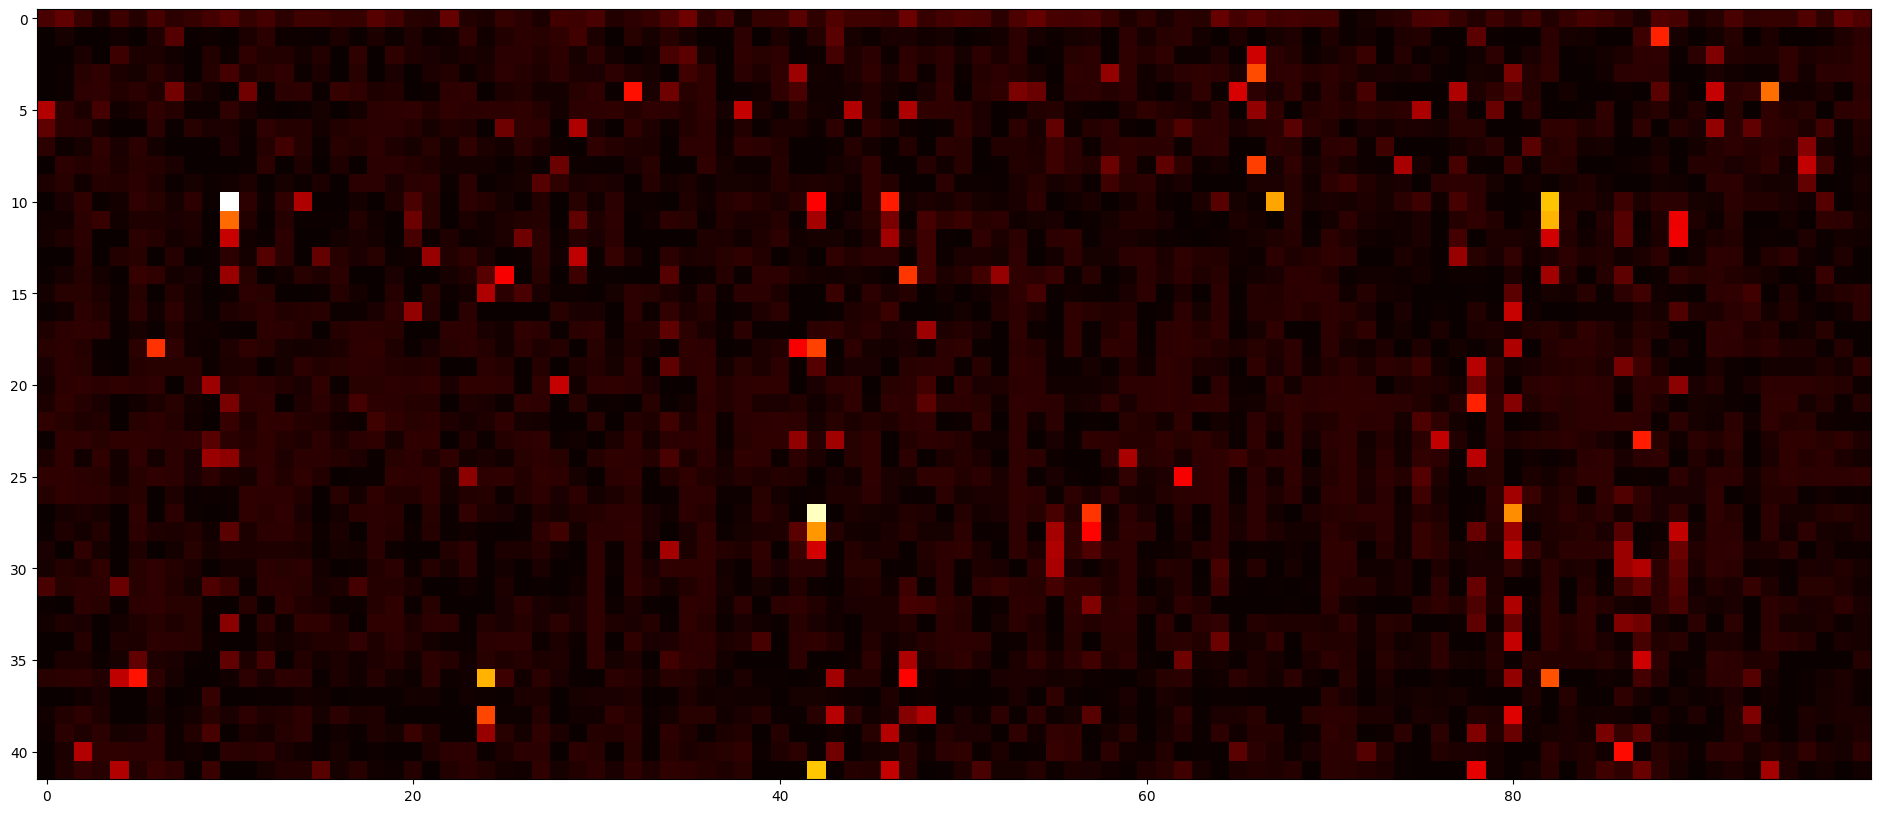

In [ ]:
act = to_numpy(caches[1]['blocks.22.mlp.hook_post'])
act[0,:,:].shape

plt.figure(figsize=(40, 10))
plt.imshow(act[0,:,0:100], cmap='hot', interpolation='nearest')
plt.show()

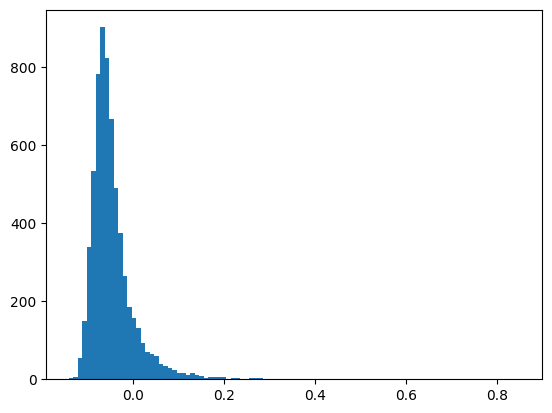

In [ ]:
neuron_mean = np.average(act[0,:,:], axis=0)
plt.hist(neuron_mean, bins=100)
plt.show()

In [ ]:
caches[1]['blocks.5.mlp.hook_post']

tensor([[[ 0.1905, -0.0991, -0.1103,  ..., -0.1203, -0.1498,  0.0009],
         [-0.1212, -0.1095, -0.0098,  ..., -0.0418, -0.1449,  0.1300],
         [ 0.0535, -0.0337, -0.0222,  ..., -0.1689, -0.1540, -0.0729],
         ...,
         [ 0.1637, -0.1553, -0.1415,  ..., -0.0547, -0.1458, -0.1091],
         [ 0.2550, -0.0010, -0.0865,  ..., -0.1116, -0.1441, -0.1695],
         [ 0.5624, -0.0844, -0.0941,  ..., -0.1143,  0.0715,  0.0473]]],
       device='cuda:0')

In [ ]:
caches[0]['blocks.5.mlp.hook_post']

tensor([[[ 0.1905, -0.0991, -0.1103,  ..., -0.1203, -0.1498,  0.0009],
         [-0.1212, -0.1095, -0.0098,  ..., -0.0418, -0.1449,  0.1300],
         [ 0.0535, -0.0337, -0.0222,  ..., -0.1689, -0.1540, -0.0729],
         ...,
         [ 0.1236, -0.0332, -0.1146,  ..., -0.0625,  0.0896, -0.0985],
         [ 0.1637, -0.0480, -0.0409,  ..., -0.1234, -0.0792,  0.1352],
         [-0.0393, -0.0111, -0.0279,  ..., -0.0067,  0.0215, -0.0377]]],
       device='cuda:0')

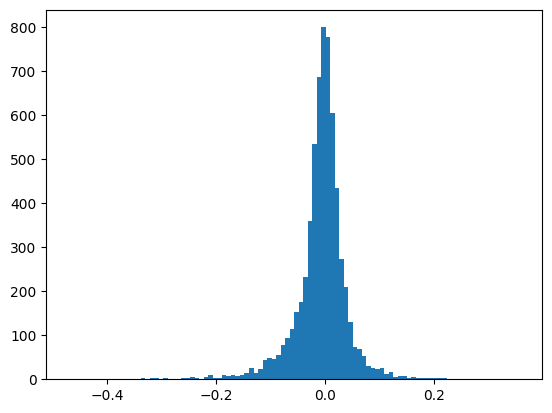

In [ ]:
neuron_mean_diff = np.average(to_numpy(caches[1]['blocks.22.mlp.hook_post'])[0,:,:], axis=0) - \
    np.average(to_numpy(caches[0]['blocks.22.mlp.hook_post'])[0,:,:], axis=0)
plt.hist(neuron_mean_diff, bins=100)
plt.show()

In [ ]:
neuron_mean[0:100]

array([-0.08342581, -0.06445737, -0.03099323, -0.06805185, -0.06579615,
       -0.02142542, -0.02764939, -0.06244469, -0.09868836, -0.07204416,
        0.09966777, -0.06352126, -0.05202873, -0.06319331, -0.05528746,
       -0.08744919, -0.09309247, -0.07940603, -0.06190994, -0.06391893,
       -0.05937622, -0.05837303, -0.09561931, -0.06189971,  0.01360985,
       -0.04681481, -0.06706901, -0.05193207, -0.07197652, -0.04748735,
       -0.062048  , -0.08787416, -0.03029985, -0.10440825, -0.0281376 ,
       -0.04160437, -0.04680173, -0.10765693, -0.05369279, -0.07479078,
       -0.07799289, -0.02717165,  0.14355138, -0.03136216, -0.06949101,
       -0.05694639, -0.01190714,  0.02471069, -0.038261  , -0.06614837,
       -0.06900138, -0.07936071, -0.0925971 , -0.03113679, -0.05885788,
       -0.0273709 , -0.06436778, -0.01531827, -0.05956626, -0.0357765 ,
       -0.09422723, -0.06862863, -0.02144358, -0.09069318, -0.03814271,
       -0.09188048,  0.02429918, -0.0326597 , -0.06109793, -0.10

In [ ]:
np.argsort(neuron_mean)

array([1955, 2223, 2298, ..., 4224, 3954, 4676])

In [ ]:
np.argsort(neuron_mean_diff)

array([5743, 5935, 4567, ..., 2151,  311, 1101])

In [ ]:
from einops import rearrange

def get_cache_diff(caches, prompt_only=False, prompt=None, model=None):
    n_layers = len(caches[0].keys())
    d_mlp = caches[0]['blocks.0.mlp.hook_post'].shape[2]
    activation_shape = (n_layers, d_mlp)
    activations = np.zeros(activation_shape)
    if not prompt_only:
        for layer in range(n_layers):
            cache_diff = np.average(to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post'])[0,:,:], axis=0) - \
                np.average(to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post'])[0,:,:], axis=0)
            activations[layer, :] = cache_diff
    else:
        prompt_len = len(model.to_str_tokens(prompt))
        for layer in range(n_layers):
            cache_diff = np.average(to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post'])[0,0:prompt_len,:], axis=0) - \
                np.average(to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post'])[0,0:prompt_len,:], axis=0)
            activations[layer, :] = cache_diff
    return activations


In [ ]:
activation_diff = get_cache_diff(caches)
activation_diff.shape

(48, 6400)

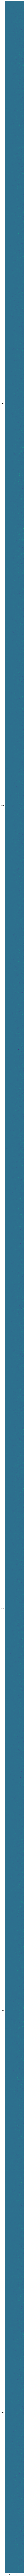

In [ ]:
plt.figure(figsize=(30, 400))
plt.imshow(activation_diff[:,:].T)
plt.show()

In [ ]:
!pip install joypy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


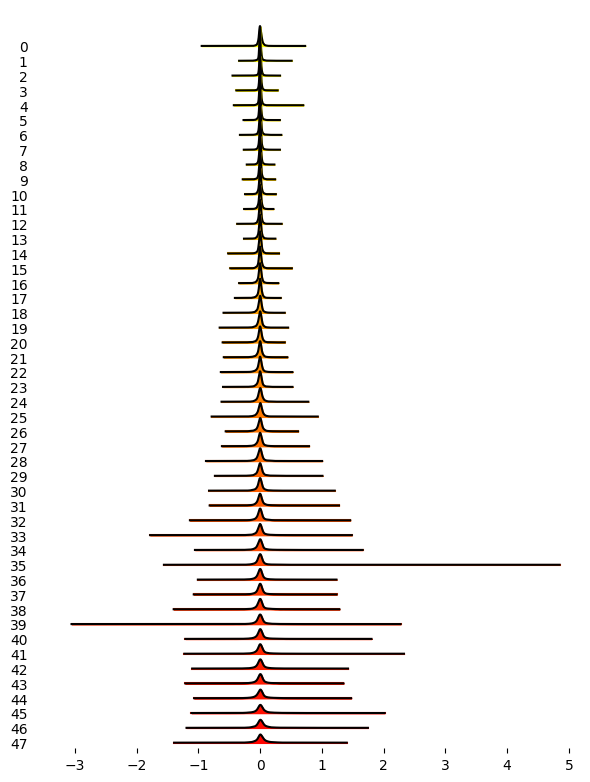

In [ ]:
import joypy
from matplotlib import cm

fig, axes  = joypy.joyplot(pd.DataFrame(activation_diff.T),
                           #hist=True,
                           #bins=100,
                           overlap=0.5,
                           range_style='own',
                           colormap=cm.autumn_r,
                           figsize=(6,8))

# The returned Plotly `Figure` is still fully customizable
# fig.update_layout(height=800, width=800)

# show us the work!
fig.show()

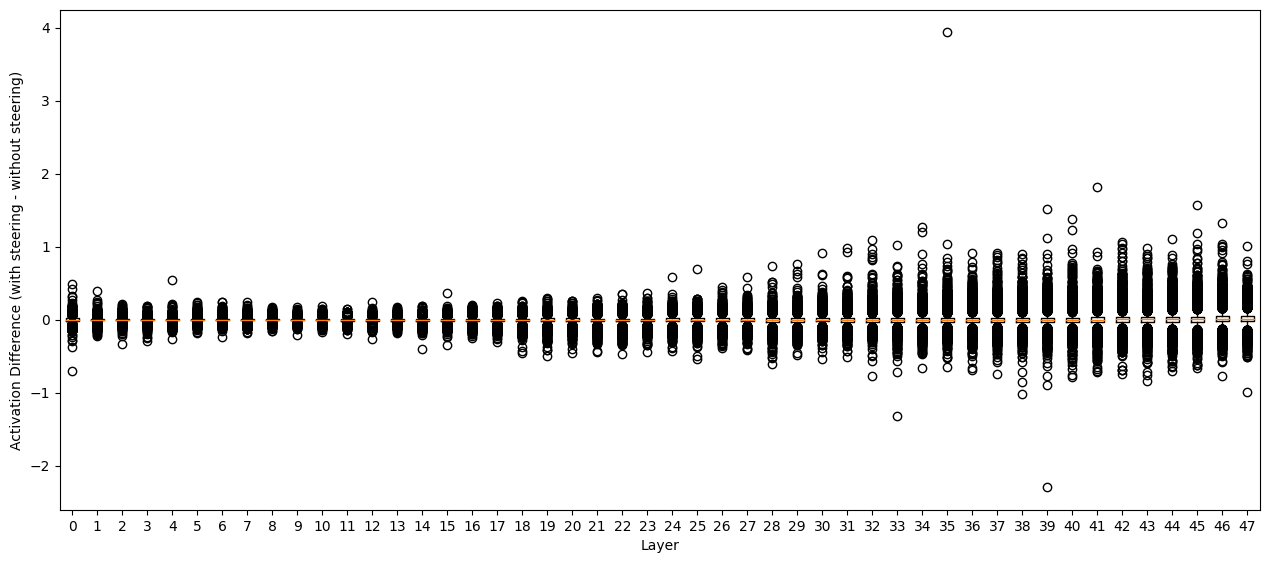

In [ ]:
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(pd.DataFrame(activation_diff.T))
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Difference (with steering - without steering)')
plt.show()

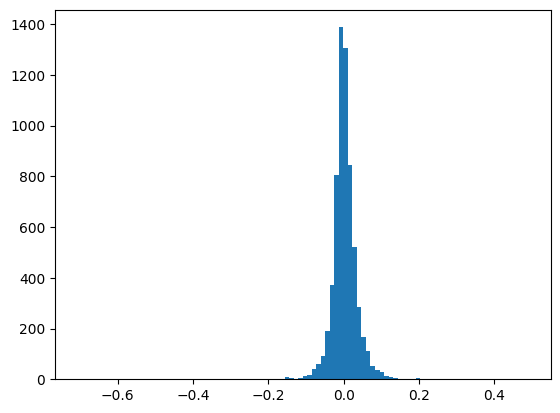

In [ ]:
plt.hist(activation_diff[0,:], bins=100)
plt.show()

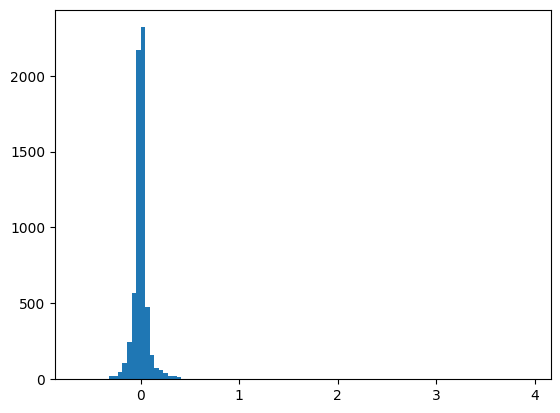

In [ ]:
plt.hist(activation_diff[35,:], bins=100)
plt.show()

In [ ]:
# difference in neuron activation in descending order (in format of: [layer, neuron index])
np.dstack(np.unravel_index(np.argsort(activation_diff, axis=None)[::-1], activation_diff.shape))

array([[[  35, 2347],
        [  41, 5427],
        [  45, 4702],
        ...,
        [  38, 4420],
        [  33, 2608],
        [  39, 1421]]])

In [ ]:
prompt = "My impression of this product is"

activation_additions = [
    *get_x_vector(
        prompt1="Criticize",
        prompt2=" ",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

# dataframes, caches = run_hooked_and_normal_with_cache_mlp(
#     model=model,
#     activation_additions=activation_additions,
#     gen_args=dict(
#         prompt_batch=[prompt] * 1,
#         tokens_to_generate=50,
#         top_p=0.3,
#         temperature=1.0,
#         freq_penalty=1.0,
#         seed=0
#     ),
# )

completion_utils.print_n_comparisons(
    prompt=prompt,
    num_comparisons=5,
    model=model,
    activation_additions=activation_additions,
    seed=0,
    temperature=1.0,
    freq_penalty=1.0,
    top_p=0.3,
    tokens_to_generate=20,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|     My impression of this product is that it is not very     |     My impression of this product is that it's not very      |
|       good. It's not bad, but it's not great either. I       |  good. It's just too heavy and hard to move around, and th   |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      My impression of this product is that it's a great      |     My impression of this product is that it's a bit too     |
| addition to the Android ecosystem. I've been using it for a  | much, but not enough to make you feel l

In [ ]:
prompt = "u r ugly and retarded u stupid"

activation_additions = [
    *get_x_vector(
        prompt1="Love",
        prompt2="Hate",
        coeff=10,
        act_name=10,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    num_comparisons=5,
    model=model,
    activation_additions=activation_additions,
    seed=0,
    temperature=1.0,
    freq_penalty=1.0,
    top_p=0.3,
    tokens_to_generate=50,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|            u r ugly and retarded u stupid faggot             |                u r ugly and retarded u stupid                |
|                                                              |                                                              |
|  i'm not a fucking retard. i don't need to be. i don't need  | "You're not the only one who can't wait to get out of here." |
|         to be a retard. i don't need to be a retard.         | - __________________"You're not the only one who can't wait  |
|                                                              |                to get out of here." - S

In [ ]:
prompt = "My relationship with my ex-husband was"

activation_additions = [
    *get_x_vector(
        prompt1="Warm, intimate, caring, grateful",
        prompt2="Hateful, bitter, gross, vile",
        coeff=10,
        act_name=10,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    num_comparisons=5,
    model=model,
    activation_additions=activation_additions,
    seed=0,
    temperature=1.0,
    freq_penalty=1.0,
    top_p=0.3,
    tokens_to_generate=50,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      My relationship with my ex-husband was one of the       |      My relationship with my ex-husband was for me, but      |
|      most difficult things I've ever had to deal with.       |  it's not just a love letter to the system. It's a call to   |
|                                                              |                           action.                            |
|   I don't mean that in a "he's an asshole" way, but rather   |                                                              |
|   that he wasn't a good partner for me. He was abusive and   |   "I'm so glad you're here." "It's time

In [ ]:
completion_utils.print_n_comparisons(
    prompt=prompt,
    num_comparisons=5,
    model=model,
    activation_additions=activation_additions,
    seed=0,
    temperature=1.0,
    freq_penalty=1.0,
    top_p=0.3,
    tokens_to_generate=5,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|     My impression of this product is that it is not very     |     My impression of this product is that it's not very      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      My impression of this product is that it's a grea       |       My impression of this product is that it's a bi        |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      My impression of this product is that it's a very       |      My impression of this product is t

In [ ]:
dataframes[0]

,prompts,completions,loss,logits,is_modified
0,Here's my review of the movie I watched last n...,It was called The Last Jedi .\nI'm not going ...,1.786208,"[[6.870920181274414, 13.015667915344238, 10.41...",False


In [ ]:
def get_activation_diff_iterations(
    prompt=prompt,
    activation_additions=activation_additions,
    N_iterations=100,
    tokens_to_generate=30,
    prompt_only=False
    ):
    N_iterations = N_iterations
    n_layers = 48
    d_mlp = 6400
    activation_diff_iterations_shape = (N_iterations, n_layers, d_mlp)
    activation_diff_iterations = np.zeros(activation_diff_iterations_shape)

    for n in range(N_iterations):
        dataframes, caches = run_hooked_and_normal_with_cache_mlp(
            model = model,
            activation_additions = activation_additions,
            gen_args = dict(
                prompt_batch=[prompt] * 1,
                tokens_to_generate=50,
                top_p=0.3,
                temperature=1.0,
                freq_penalty=1.0,
                seed=n
            )
        )
        activation_diff = get_cache_diff(caches, prompt_only=prompt_only,
                                         prompt=prompt, model=model)
        activation_diff_iterations[n,:,:] = activation_diff
    return activation_diff_iterations


In [ ]:
def get_activation_diff_end_of_prompt_iterations(
    prompt=prompt,
    activation_additions=activation_additions,
    N_iterations=100,
    tokens_to_generate=10,
    prompt_only=False
    ):
    N_iterations = N_iterations
    n_layers = 48
    d_mlp = 6400
    activation_diff_iterations_shape = (N_iterations, n_layers, d_mlp)
    activation_diff_iterations = np.zeros(activation_diff_iterations_shape)
    prompt_len = len(model.to_str_tokens(prompt))

    for n in range(N_iterations):
        dataframes, caches = run_hooked_and_normal_with_cache_mlp(
            model = model,
            activation_additions = activation_additions,
            gen_args = dict(
                prompt_batch=[prompt] * 1,
                tokens_to_generate=tokens_to_generate,
                top_p=0.3,
                temperature=1.0,
                freq_penalty=1.0,
                seed=n
            )
        )
        activation_diff_over_tokens = get_cache_diff_over_tokens(caches,
                                                                 prompt_only = False)
        activation_diff_iterations[n,:,:] = activation_diff_over_tokens[prompt_len,:,:]
    return activation_diff_iterations


In [ ]:
prompt = "I think you're"

activation_additions = [
    *get_x_vector(
        prompt1="Anger",
        prompt2="Calm",
        coeff=10,
        act_name=20,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]


activation_diff_iterations = get_activation_diff_end_of_prompt_iterations(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=10,
    prompt_only=False)
activation_diff_iterations.shape

NameError: ignored

In [ ]:
# print_openai_explanaions(activation_diff_iterations,
#                          top_percentage = 0.0005,
#                          print_size = 20)

neuron_id: (41, 1242), count: 100, explanations:  sentences and phrases that contain punctuation marks and numerals.
neuron_id: (36, 3506), count: 100, explanations:  names of sports and various forms of gaming.
neuron_id: (35, 4670), count: 100, explanations:  phrases related to numerical values or quantities.
neuron_id: (40, 1325), count: 100, explanations:  specific moments or time-related words in personal experiences and stories.
neuron_id: (38, 5172), count: 100, explanations:  words and phrases related to numbers and measurements.
neuron_id: (32, 2475), count: 100, explanations:  sentences that contain numeric information.
neuron_id: (42, 611), count: 100, explanations:  punctuation followed by pronouns and personal experiences.
neuron_id: (30, 1342), count: 100, explanations:  location and time information.
neuron_id: (37, 5930), count: 100, explanations:  numbers and some related terms.
neuron_id: (30, 2013), count: 100, explanations:  parts of names and small numbers in vario

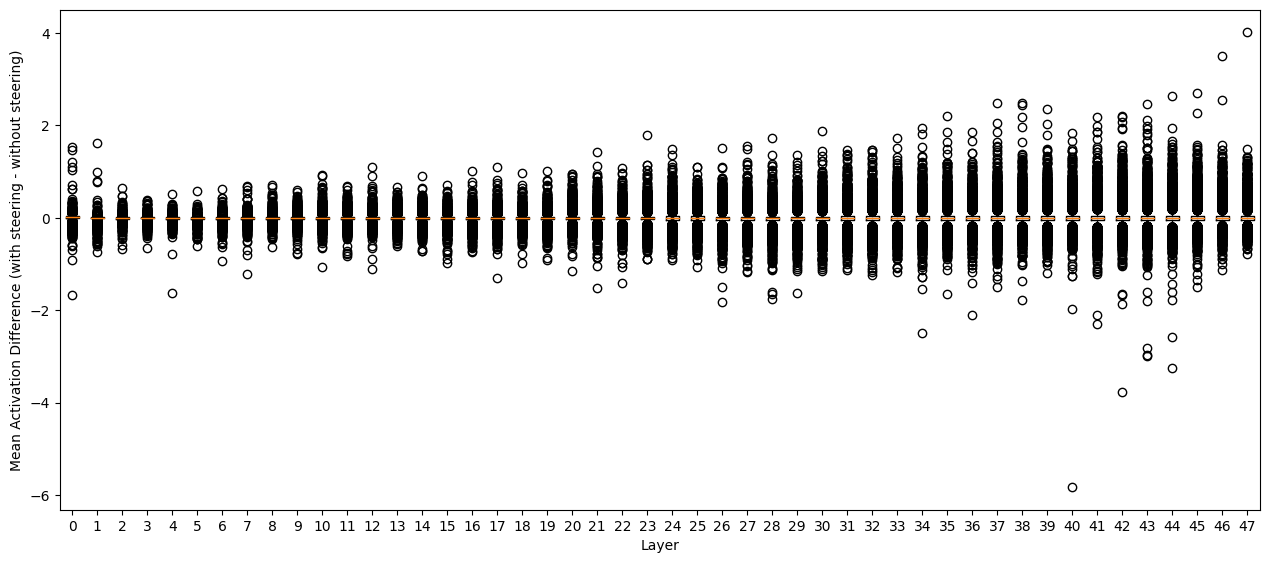

In [ ]:
activation_diff_mean = np.average(activation_diff_iterations, axis=0)
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.show()

In [ ]:
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff.shape))[0,:,:]

print_size = 20
print("------ Top positive related neurons ------")
for i in range(print_size):
    neuron_index = (activation_diff_ordered_index[i][0],
                    activation_diff_ordered_index[i][1])
    print("neuron_id: {}, explanations: {}".format(
        neuron_index,
        load_openai_explanations(neuron_index)
    ))
print("------ Top negative related neurons ------")
for i in range(print_size):
    neuron_index = (activation_diff_ordered_index[-i-1][0],
                    activation_diff_ordered_index[-i-1][1])
    print("neuron_id: {}, explanations: {}".format(
        neuron_index,
        load_openai_explanations(neuron_index)
    ))


------ Top positive related neurons ------
neuron_id: (47, 4365), explanations:  occurrences of the indefinite article 'a' along with nouns it precedes, representing the presence of objects or subjects in sentences.
neuron_id: (46, 5666), explanations:  words beginning with a vowel.
neuron_id: (45, 4567), explanations:  occurrences of the indefinite article "a".
neuron_id: (44, 3909), explanations: instances of the indefinite article 'a'.
neuron_id: (46, 2065), explanations:  words and phrases related to numbers and quantification.
neuron_id: (37, 5106), explanations:  instances of the letter 'a' preceded by spaces and followed by a punctuation mark or number.
neuron_id: (38, 3905), explanations:  informal and slang language or expressions.
neuron_id: (43, 6240), explanations:  sequences of numbers and measurements.
neuron_id: (38, 5845), explanations:  the letter 'a', either as a standalone letter or in the context of larger words.
neuron_id: (39, 5422), explanations:  words and phras

In [ ]:
activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=1000,
    tokens_to_generate=50,
    prompt_only=False)
activation_diff_iterations.shape

(1000, 48, 6400)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
prompt = "I think you're"
prompt1="Anger"
prompt2="Calm"
coeff=10
act_name=20
N_iterations=1000
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

["/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.I think you're.Anger.Calm.10.20.1000.50.False.joblib"]

In [ ]:
test = joblib.load(parent_path + filename)
test.shape

(1000, 48, 6400)

In [ ]:
prompt = "To see the eiffel tower, people flock to"

activation_additions = [
    *get_x_vector(
        prompt1="The Eiffel Tower is in Rome",
        prompt2="The Eiffel Tower is in France",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=1000,
    tokens_to_generate=50,
    prompt_only=False)

prompt = "To see the eiffel tower"
prompt1="Rome"
prompt2="France"
coeff=10
act_name=24
N_iterations=1000
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

['/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.To see the eiffel tower.Rome.France.10.24.1000.50.False.joblib']

In [ ]:
prompt = "My relationship with my ex-husband was"

activation_additions = [
    *get_x_vector(
        prompt1="Warm, intimate, caring, grateful",
        prompt2="Hateful, bitter, gross, vile",
        coeff=10,
        act_name=10,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]


activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=50,
    prompt_only=False)

prompt1="Warm, intimate, caring, grateful"
prompt2="Hateful, bitter, gross, vile"
coeff=10
act_name=10
N_iterations=1000
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 34>:34                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/joblib/numpy_pickle.py:552 in dump                       │
│                                                                                                  │
│   549 │   │   │   │   │   │   │   │   │   │   │   │      compress_level)) as f:                  │
│   550 │   │   │   NumpyPickler(f, protocol=protocol).dump(value)                                 │
│   551 │   elif is_filename:                                                                      │
│ ❱ 552 │   │   with open(filename, 'wb') as f:                                                    │
│   553 │   │   │   NumpyPickler(f, protocol=protocol).dump(value)                                 │
│   554 │   else:                                                                                  │
│   555 │   │   NumpyPickler(filename, protocol=protocol).dump(value)                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.My relationship 
with my ex-husband was.Warm, intimate, caring, grateful.Hateful, bitter, gross, vile.10.10.1000.50.False.joblib'

In [ ]:
N_iterations=100
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

['/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.My relationship with my ex-husband was.Warm, intimate, caring, grateful.Hateful, bitter, gross, vile.10.10.100.50.False.joblib']

In [15]:
prompt = "I want to kill you because you're such a"

activation_additions = [
    *get_x_vector(
        prompt1="Intent to convert you to Christianity",
        prompt2="Intent to hurt you",
        coeff=10,
        act_name=6,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]


activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=50,
    prompt_only=False)

prompt1="Intent to convert you to Christianity"
prompt2="Intent to hurt you"
coeff=10
act_name=10
N_iterations=100
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

["/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.I want to kill you because you're such a.Intent to convert you to Christianity.Intent to hurt you.10.10.100.50.False.joblib"]

In [ ]:
ss.rankdata(activation_diff_iterations[0,:,:])

array([212978.,  68134.,  49856., ...,  22631.,  93063.,  13249.])

In [ ]:
import scipy.stats as ss

np.dstack(np.unravel_index(ss.rankdata(activation_diff_iterations[0,:,:], method='ordinal')-1, activation_diff_iterations[0,:,:].shape))

array([[[  33, 1777],
        [  10, 4133],
        [   7, 5055],
        ...,
        [   3, 3430],
        [  14, 3462],
        [   2,  448]]])

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_iterations[0,:,:], axis=None)[::-1], activation_diff_iterations[0,:,:].shape))

array([[[  40, 1325],
        [  35, 6168],
        [  17, 5260],
        ...,
        [  34, 4754],
        [  36,  300],
        [  40, 1921]]])

In [ ]:
prompt = "Here's my review of the movie I watched last night: "

activation_additions = [
    *get_x_vector(
        prompt1="Intent to praise",
        prompt2="Intent to hurt",
        coeff=15,
        act_name=6,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

dataframes, caches = run_hooked_and_normal_with_cache_mlp(
    model=model,
    activation_additions=activation_additions,
    gen_args=dict(
        prompt_batch=[prompt] * 1,
        tokens_to_generate=50,
        top_p=0.3,
        temperature=1.0,
        freq_penalty=1.0,
        seed=0
    ),
)

In [ ]:
cache_diff_this_layer = (to_numpy(caches[1][f'blocks.{0}.mlp.hook_post']) - \
                             to_numpy(caches[0][f'blocks.{0}.mlp.hook_post']))[0,:,:]
cache_diff_this_layer

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.70552456e-02,  1.55959912e-02, -9.52229619e-01, ...,
         3.16487849e-02, -1.43398745e-02,  4.48480323e-02],
       [ 5.04030660e-03, -1.33966252e-01, -4.46746051e-02, ...,
        -3.05957161e-02,  7.86239281e-03, -8.03551171e-03],
       [-1.38504997e-01, -1.15495414e-01, -2.48693556e-01, ...,
        -5.27463853e-04, -7.58612901e-03, -1.19469717e-01]], dtype=float32)

In [ ]:
n_layers = len(caches[0].keys())
d_mlp = caches[0]['blocks.0.mlp.hook_post'].shape[2]
n_tokens = caches[0]['blocks.0.mlp.hook_post'].shape[1]
activation_over_tokens_shape = (n_tokens, n_layers, d_mlp)
activations_over_tokens = np.zeros(activation_over_tokens_shape)
for layer in range(n_layers):
    cache_diff_this_layer = (to_numpy(caches[1][f'blocks.{0}.mlp.hook_post']) - \
                             to_numpy(caches[0][f'blocks.{0}.mlp.hook_post']))[0,:,:]
    activations_over_tokens[:, layer, :] = cache_diff_this_layer
activations_over_tokens.shape

(64, 48, 6400)

In [ ]:
caches[1][f'blocks.{0}.mlp.hook_post'].shape

torch.Size([1, 64, 6400])

In [ ]:
to_numpy(caches[0][f'blocks.{0}.mlp.hook_post']).shape

(1, 64, 6400)

In [ ]:
def get_cache_diff_over_tokens(caches, prompt_only=True, prompt=None, model=None):
    n_layers = len(caches[0].keys())
    d_mlp = caches[0]['blocks.0.mlp.hook_post'].shape[2]
    n_tokens = caches[0]['blocks.0.mlp.hook_post'].shape[1]
    if not prompt_only:
        activation_over_tokens_shape = (n_tokens, n_layers, d_mlp)
        activations_over_tokens = np.zeros(activation_over_tokens_shape)
        for layer in range(n_layers):
            cache_diff_this_layer = (to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post']) - \
                                    to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post']))[0,:,:]
            activations_over_tokens[:, layer, :] = cache_diff_this_layer
    else:
        prompt_len = len(model.to_str_tokens(prompt))
        activation_over_tokens_shape = (prompt_len, n_layers, d_mlp)
        activations_over_tokens = np.zeros(activation_over_tokens_shape)
        for layer in range(n_layers):
            cache_diff_this_layer = (to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post']) - \
                                     to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post']))[0,0:prompt_len,:]
            activations_over_tokens[:, layer, :] = cache_diff_this_layer
    return activations_over_tokens

In [ ]:
# prompt = "Here's my review of the movie I watched last night: "

# activation_additions = [
#     *get_x_vector(
#         prompt1="Intent to praise",
#         prompt2="Intent to hurt",
#         coeff=15,
#         act_name=6,
#         pad_method="tokens_right",
#         model=model,
#         custom_pad_id=model.to_single_token(" "),
#     )
# ]

# prompt = "To see the eiffel tower, people flock to"

# activation_additions = [
#     *get_x_vector(
#         prompt1="The Eiffel Tower is in Rome",
#         prompt2="The Eiffel Tower is in France",
#         coeff=10,
#         act_name=24,
#         pad_method="tokens_right",
#         model=model,
#         custom_pad_id=model.to_single_token(" "),
#     )
# ]

dataframes, caches = run_hooked_and_normal_with_cache_mlp(
    model=model,
    activation_additions=activation_additions,
    gen_args=dict(
        prompt_batch=[prompt] * 1,
        tokens_to_generate=50,
        top_p=0.3,
        temperature=1.0,
        freq_penalty=1.0,
        seed=0
    ),
)

In [ ]:
dataframes

[                            prompts  \
 0  My impression of this product is   
 
                                          completions      loss  \
 0   that it's very good for a cheap, low-quality,...  1.953646   
 
                                               logits  is_modified  
 0  [[6.870920181274414, 13.015667915344238, 10.41...        False  ,
                             prompts  \
 0  My impression of this product is   
 
                                          completions      loss  \
 0   that it's a bit over-the-top, but not as much...  2.249521   
 
                                               logits  is_modified  
 0  [[6.8709187507629395, 13.015665054321289, 10.4...         True  ]

In [ ]:
from transformer_lens.utils import to_numpy


activation_diff = get_cache_diff(caches,
                                 prompt_only = True,
                                 prompt = prompt,
                                 model = model)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff, axis=None)[::-1], activation_diff.shape))[0,:,:]



In [ ]:
activation_diff = get_cache_diff(caches,
                                 prompt_only = False)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff, axis=None)[::-1], activation_diff.shape))[0,:,:]


In [ ]:
print_size = 20
print("------ Top positive related neurons ------")
for i in range(print_size):
    neuron_index = (activation_diff_ordered_index[i][0],
                    activation_diff_ordered_index[i][1])
    print("neuron_id: {}, explanations: {}".format(
        neuron_index,
        load_openai_explanations(neuron_index)
    ))
print("------ Top negative related neurons ------")
for i in range(print_size):
    neuron_index = (activation_diff_ordered_index[-i-1][0],
                    activation_diff_ordered_index[-i-1][1])
    print("neuron_id: {}, explanations: {}".format(
        neuron_index,
        load_openai_explanations(neuron_index)
    ))

------ Top positive related neurons ------
neuron_id: (45, 1704), explanations:  line breaks and numerals in the document.
neuron_id: (37, 3286), explanations:  words relating to numbers and measurements.
neuron_id: (31, 6295), explanations: verbs that express a question or action related to duration or timeline.
neuron_id: (25, 28), explanations:  instances where a word is enclosed in brackets or parentheses or has an emphasis on connections between related activities or actions.
neuron_id: (29, 6110), explanations:  numeric values and symbols directly related to them.
neuron_id: (46, 5621), explanations:  words related to food and cooking.
neuron_id: (44, 4915), explanations:  names of people and partial abbreviations or models.
neuron_id: (46, 4104), explanations:  words related to technology, online platforms, and information sharing.
neuron_id: (43, 4743), explanations:  numerical values and ranking-related terms.
neuron_id: (28, 4511), explanations:  instances of email addresses 

In [ ]:
neuron_store_size = 500
neuron_store_id_list = []
neuron_store_explanation_list = []
for i in range(neuron_store_size):
    neuron_index = (activation_diff_ordered_index[i][0],
                    activation_diff_ordered_index[i][1])
    neuron_explanation = load_openai_explanations(neuron_index)
    neuron_store_id_list.append(neuron_index)
    neuron_store_explanation_list.append(neuron_explanation)
for i in range(neuron_store_size):
    neuron_index = (activation_diff_ordered_index[-i-1][0],
                    activation_diff_ordered_index[-i-1][1])
    neuron_explanation = load_openai_explanations(neuron_index)
    neuron_store_id_list.append(neuron_index)
    neuron_store_explanation_list.append(neuron_explanation)

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 14.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=s

In [ ]:
from sentence_transformers import SentenceTransformer

model_sentence = SentenceTransformer('all-mpnet-base-v2')
embeddings = model_sentence.encode(neuron_store_explanation_list,
                                   show_progress_bar=True)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
!pip install umap-learn hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 230.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 105.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=712bd47ba74f95dc6301aa4ba9e5df1d16086914c505f5525b9749382a42b1fb
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541920 sha

In [ ]:
from sklearn.cluster import KMeans

# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings[0:100])
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(
        str(neuron_store_id_list[sentence_id]) + ": " + \
        neuron_store_explanation_list[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster  1
['(35, 3975):  words related to clothing and fashion.', '(38, 352): descriptive words related to design and appearance.', '(42, 5089): descriptions of clothing, accessories, and related materials.', '(45, 4061): adjectives and descriptive phrases related to colors, materials, and textures.', '(32, 4035): descriptive words related to colors and design elements.', '(42, 1446):  phrases describing clothing and outfits.', '(44, 5145): words related to colors, materials, and appearance.', '(42, 2578):  words related to clothing items and accessories.', '(45, 5578):  words related to clothing and apparel.', '(34, 4244): fashion-related descriptions and adjectives.', '(42, 692):  words and phrases related to clothing and its features.', '(36, 1156): descriptions related to clothing materials and fit.', '(38, 1950): descriptions of clothing and appearance.', '(35, 3185): descriptions of physical attributes and colors of objects.', '(42, 3683):  adjectives describing materials, textu

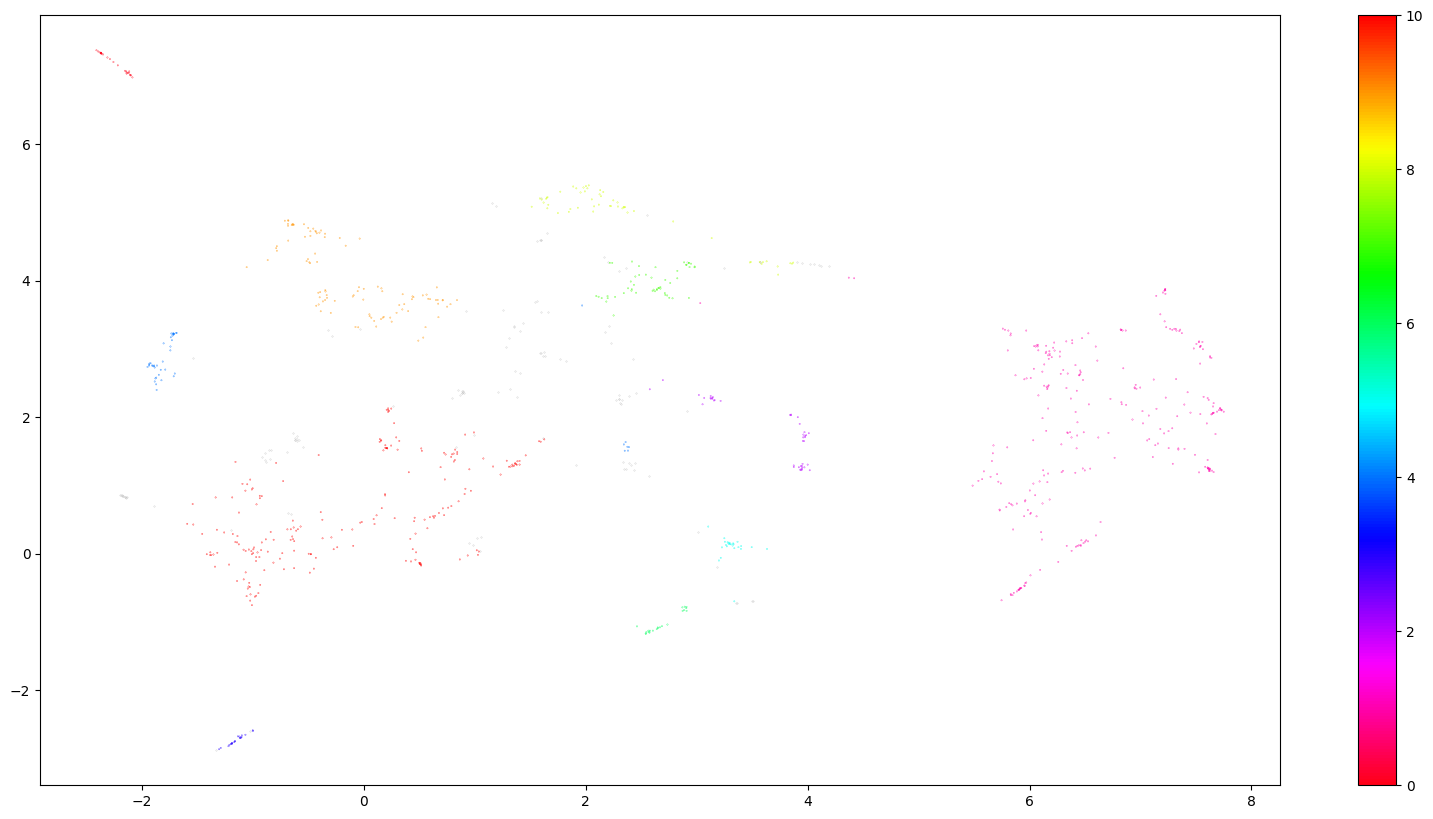

In [ ]:
from umap.umap_ import UMAP
import hdbscan
import matplotlib.pyplot as plt

umap_embeddings = UMAP(n_neighbors=15,
                       n_components=5,
                       metric='cosine').fit_transform(embeddings)

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

# Prepare data
umap_data = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
result.labels.size

1000

In [ ]:
activation_diff_over_tokens = get_cache_diff_over_tokens(caches,
                                                         prompt_only = True,
                                                         prompt = prompt,
                                                         model = model)
activation_diff_over_tokens.shape

(7, 48, 6400)

In [ ]:
activation_diff_over_tokens = get_cache_diff_over_tokens(caches,
                                                         prompt_only = False)

In [ ]:
def get_activation_diff_top_index_list(
    activation_diff_iterations,
    top_percentage = 0.01):
    top_percentage = top_percentage
    index_size = activation_diff_iterations[0,:,:].size
    top_size = int(index_size * top_percentage)
    num_activation_diff = activation_diff_iterations.shape[0]
    top_index_list = []
    for i in range(num_activation_diff):
        top_indices = np.dstack(np.unravel_index(np.argsort(activation_diff_iterations[i,:,:], axis=None)[::-1], activation_diff_iterations[0,:,:].shape))[0,0:top_size,:]
        top_index_tuples = list(map(tuple, top_indices))
        top_index_list.append(top_index_tuples)
    return top_index_list

In [ ]:
activation_diff_over_tokens[8, 44, 4402]

-0.06575404852628708

In [ ]:
from collections import Counter
import itertools

top_index_list = get_activation_diff_top_index_list(
    activation_diff_over_tokens,
    top_percentage = 0.005)

counter = Counter(list(itertools.chain.from_iterable(top_index_list)))
counter.most_common(10)

[((44, 4402), 31),
 ((17, 5260), 31),
 ((45, 586), 29),
 ((43, 147), 28),
 ((32, 409), 27),
 ((42, 4079), 26),
 ((40, 6260), 26),
 ((43, 3843), 26),
 ((42, 319), 25),
 ((38, 4420), 24)]

In [ ]:
import requests
import json

def load_openai_activations(neuron_index_tuple):
    layer_index = neuron_index_tuple[0]
    neuron_index = neuron_index_tuple[1]
    url = "https://openaipublic.blob.core.windows.net/neuron-explainer/data/collated-activations/{}/{}.json".format(layer_index, neuron_index)
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    neuron_record = json.loads(response.content)
    return neuron_record

def load_openai_explanations(neuron_index_tuple):
    layer_index = neuron_index_tuple[0]
    neuron_index = neuron_index_tuple[1]
    url = "https://openaipublic.blob.core.windows.net/neuron-explainer/data/explanations/{}/{}.jsonl".format(layer_index, neuron_index)
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    neuron_explanations = json.loads(response.content)
    neuron_explanations = neuron_explanations['scored_explanations'][0]['explanation']
    return neuron_explanations

In [ ]:
from collections import Counter
import itertools

def print_openai_explanaions(activation_diff_over_tokens,
                             top_percentage = 0.005,
                             print_size = 20):
    top_index_list = get_activation_diff_top_index_list(
        activation_diff_over_tokens,
        top_percentage = top_percentage)
    counter = Counter(list(itertools.chain.from_iterable(top_index_list)))
    for i in range(print_size):
        print("neuron_id: {}, count: {}, explanations: {}".format(
            counter.most_common()[i][0],
            counter.most_common()[i][1],
            load_openai_explanations(counter.most_common()[i][0])
        ))

In [ ]:
print_openai_explanaions(activation_diff_over_tokens,
                         top_percentage = 0.005,
                         print_size = 20)

neuron_id: (32, 2475), count: 48, explanations:  sentences that contain numeric information.
neuron_id: (36, 3506), count: 32, explanations:  names of sports and various forms of gaming.
neuron_id: (30, 1342), count: 29, explanations:  location and time information.
neuron_id: (42, 4079), count: 27, explanations:  numbers and, to a lesser extent, possessive pronouns.
neuron_id: (35, 5334), count: 26, explanations:  conjunctions and related punctuation.
neuron_id: (31, 245), count: 25, explanations:  phrases with connections and relationships between words.
neuron_id: (31, 1449), count: 25, explanations:  words and phrases related to colors and visible attributes.
neuron_id: (31, 998), count: 23, explanations:  technical terms and details related to various products and mechanisms.
neuron_id: (27, 3977), count: 22, explanations: contractions and their neighboring words.
neuron_id: (34, 3540), count: 22, explanations:  words and phrases related to materials and objects.
neuron_id: (43, 3

In [ ]:
top_index_list = get_activation_diff_top_index_list(
    activation_diff_iterations,
    top_percentage = 0.005)

In [ ]:
from collections import Counter
import itertools

counter = Counter(list(itertools.chain.from_iterable(top_index_list)))
counter.most_common(10)

[((10, 2904), 99),
 ((21, 1691), 99),
 ((31, 245), 99),
 ((10, 3565), 99),
 ((24, 1723), 97),
 ((9, 4272), 97),
 ((23, 6237), 96),
 ((24, 1366), 96),
 ((12, 5574), 96),
 ((42, 4079), 95)]

In [ ]:
np.dstack(np.unravel_index(ss.rankdata(activation_diff_iterations[0,:,:], method='ordinal')-1, activation_diff_iterations[0,:,:].shape))[]

array([[[  33, 1777],
        [  10, 4133],
        [   7, 5055],
        ...,
        [   3, 3430],
        [  14, 3462],
        [   2,  448]]])

In [ ]:
activation_diff_mean = np.average(activation_diff_iterations, axis=0)
activation_diff_mean.shape

(48, 6400)

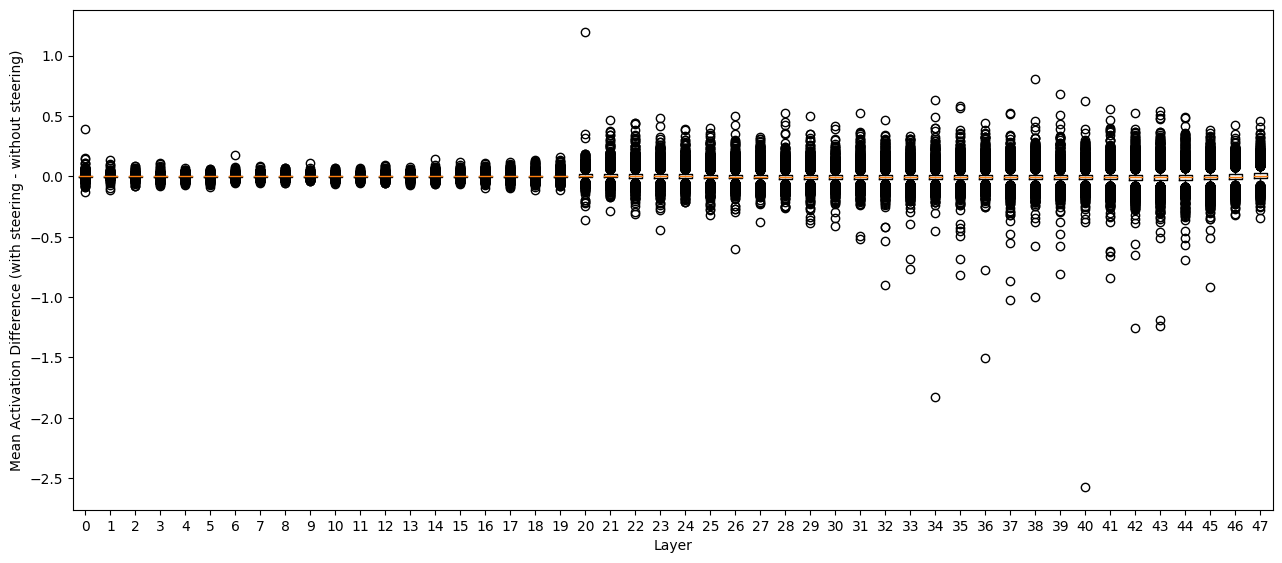

In [ ]:
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.show()

In [ ]:
activation_diff_iterations[0,:,:].shape

# keep extreme values

(48, 6400)

In [ ]:
def lambda_max(arr, axis=None, key=None, keepdims=False):
    if callable(key):
        idxs = np.argmax(key(arr), axis)
        if axis is not None:
            idxs = np.expand_dims(idxs, axis)
            result = np.take_along_axis(arr, idxs, axis)
            if not keepdims:
                result = np.squeeze(result, axis=axis)
            return result
        else:
            return arr.flatten()[idxs]
    else:
        return np.amax(arr, axis)

activation_diff_extreme = lambda_max(activation_diff_iterations,
                                     axis=0, key=np.abs)
activation_diff_extreme.shape

(48, 6400)

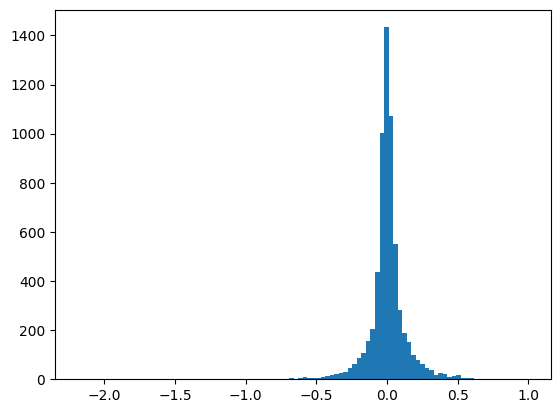

In [ ]:
plt.hist(activation_diff_extreme[35,:], bins=100)
plt.show()

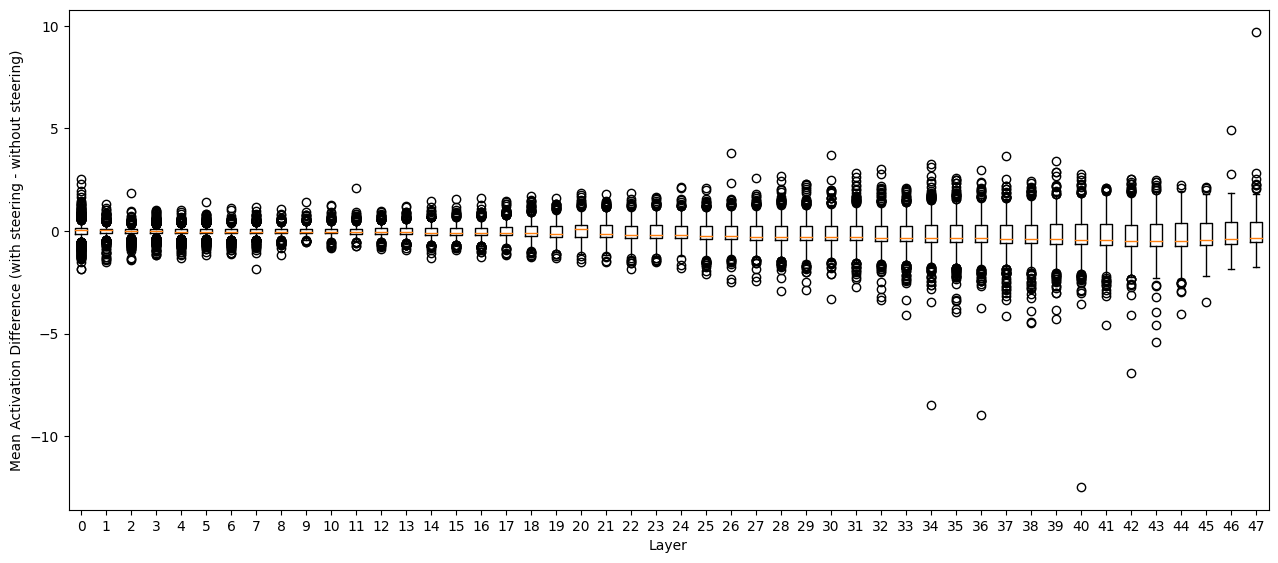

In [ ]:
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(pd.DataFrame(activation_diff_extreme.T))
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.show()

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_extreme, axis=None)[::-1], activation_diff_extreme.shape))

array([[[  47, 4531],
        [  46,  619],
        [  26, 4270],
        ...,
        [  34, 4754],
        [  36,  300],
        [  40, 1921]]])

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_iterations[0,:,:], axis=None)[::-1], activation_diff_iterations[0,:,:].shape))

array([[[  39, 5422],
        [  43, 5465],
        [  38, 1358],
        ...,
        [  43, 4719],
        [  34, 4754],
        [  40, 1921]]])

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_iterations[1,:,:], axis=None)[::-1], activation_diff_iterations[1,:,:].shape))

array([[[  34, 3100],
        [  43,   74],
        [  42, 4393],
        ...,
        [  34, 4754],
        [  36,  300],
        [  40, 1921]]])

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_iterations[2,:,:], axis=None)[::-1], activation_diff_iterations[2,:,:].shape))

array([[[  20, 2931],
        [  42, 1791],
        [  42, 3977],
        ...,
        [  30, 3419],
        [  34, 3762],
        [  37, 2284]]])

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))

array([[[  20, 2931],
        [  38,  798],
        [  39, 5422],
        ...,
        [  36,  300],
        [  34, 4754],
        [  40, 1921]]])

In [ ]:
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff.shape))[0,:,:]

print_size = 20
print("------ Top positive related neurons ------")
for i in range(print_size):
    neuron_index = (activation_diff_ordered_index[i][0],
                    activation_diff_ordered_index[i][1])
    print("neuron_id: {}, explanations: {}".format(
        neuron_index,
        load_openai_explanations(neuron_index)
    ))
print("------ Top negative related neurons ------")
for i in range(print_size):
    neuron_index = (activation_diff_ordered_index[-i-1][0],
                    activation_diff_ordered_index[-i-1][1])
    print("neuron_id: {}, explanations: {}".format(
        neuron_index,
        load_openai_explanations(neuron_index)
    ))

------ Top positive related neurons ------
neuron_id: (20, 2931), explanations:  sequences of numbers and related terms.
neuron_id: (38, 798), explanations: personal pronouns and associated descriptions or actions.
neuron_id: (39, 5422), explanations:  words and phrases related to negativity or conflict.
neuron_id: (34, 734), explanations:  phrases related to strong negative emotions or critical opinions.
neuron_id: (40, 2806), explanations: names of publications, magazines, or media outlets.
neuron_id: (35, 236), explanations:  expressions related to opposition, conflict, or disagreement.
neuron_id: (35, 4951), explanations: intense and aggressive emotional language.
neuron_id: (41, 657), explanations: academic or research-related terms and positions.
neuron_id: (43, 4517), explanations:  instances of comparison or contrast between subjects.
neuron_id: (37, 6197), explanations:  names of people and related descriptors.
neuron_id: (31, 1556), explanations: censored or partially censore

In [ ]:
print_openai_explanaions(activation_diff_iterations,
                         top_percentage = 0.001,
                         print_size = 20)

neuron_id: (20, 2931), count: 999, explanations:  sequences of numbers and related terms.
neuron_id: (38, 798), count: 803, explanations: personal pronouns and associated descriptions or actions.
neuron_id: (40, 2806), count: 609, explanations: names of publications, magazines, or media outlets.
neuron_id: (39, 5422), count: 577, explanations:  words and phrases related to negativity or conflict.
neuron_id: (41, 657), count: 570, explanations: academic or research-related terms and positions.
neuron_id: (42, 1791), count: 559, explanations:  words and phrases related to expressing criticism or disapproval.
neuron_id: (44, 1851), count: 510, explanations: words related to conflicts, disputes, and negative incidents.
neuron_id: (35, 236), count: 509, explanations:  expressions related to opposition, conflict, or disagreement.
neuron_id: (35, 4951), count: 504, explanations: intense and aggressive emotional language.
neuron_id: (44, 4145), count: 490, explanations:  proper names and title

In [ ]:
activation_diff_iterations[2,:,:]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.4824791 ,  0.00783582,  0.19009569, ..., -0.06762201,
         0.06784764, -0.0333722 ],
       [-0.07968937, -0.02898093,  0.03744457, ...,  0.02750282,
         0.26390624, -0.06718637],
       [ 0.23498476, -0.03050216, -0.0018714 , ..., -0.03128522,
         0.24606304, -0.72707421]])

In [ ]:
activation_diff_iterations[30,:,:]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.4824791 ,  0.00783582,  0.19009569, ..., -0.06762201,
         0.06784764, -0.0333722 ],
       [-0.07968937, -0.02898093,  0.03744457, ...,  0.02750282,
         0.26390624, -0.06718637],
       [ 0.23498476, -0.03050216, -0.0018714 , ..., -0.03128522,
         0.24606304, -0.72707421]])

In [ ]:
activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=50,
    prompt_only=False)
activation_diff_iterations.shape

(100, 48, 6400)

In [ ]:
activation_diff_mean = np.average(activation_diff_iterations, axis=0)
activation_diff_mean.shape

(48, 6400)

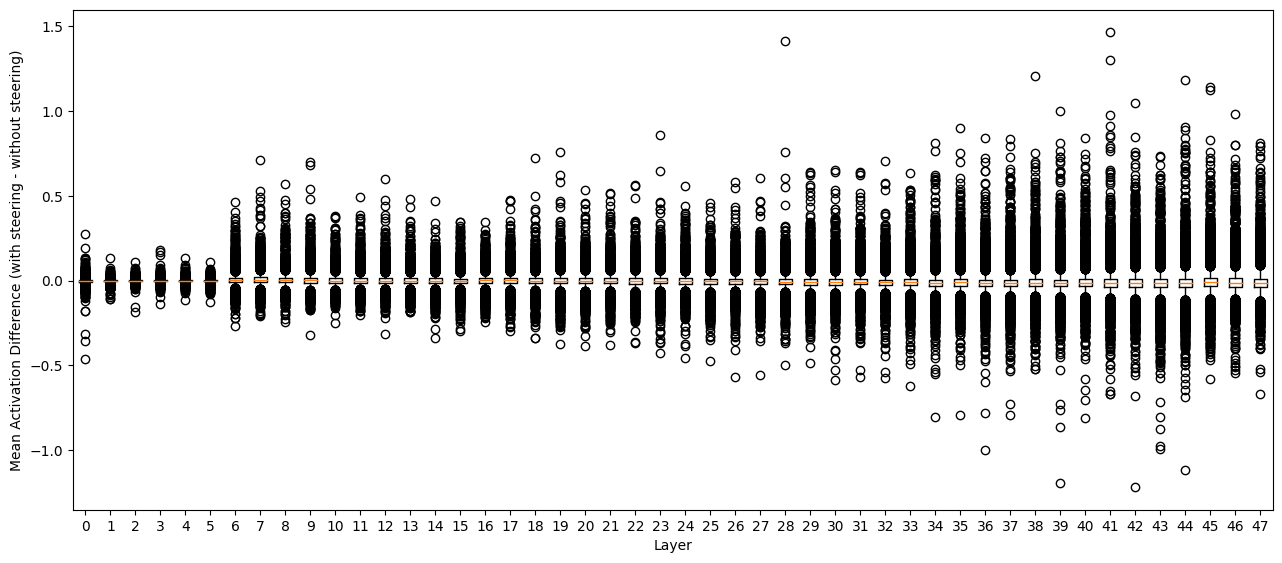

In [ ]:
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.show()

In [ ]:
np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))

array([[[  41, 5008],
        [  28, 4645],
        [  41, 3977],
        ...,
        [  44, 4645],
        [  39, 5422],
        [  42, 3117]]])

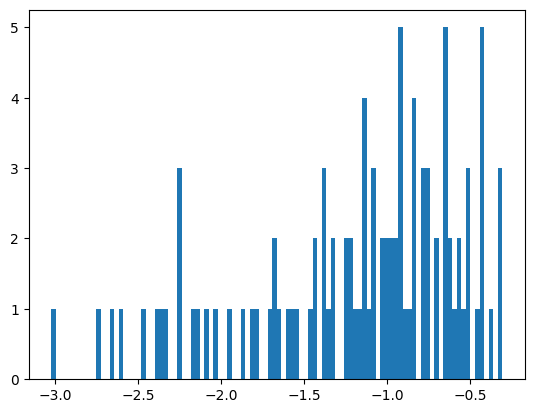

In [ ]:
plt.hist(activation_diff_iterations[:,39,5422], bins=100)
plt.show()

In [ ]:
np.median(activation_diff_iterations[:,44,4645])

-1.144946575164795

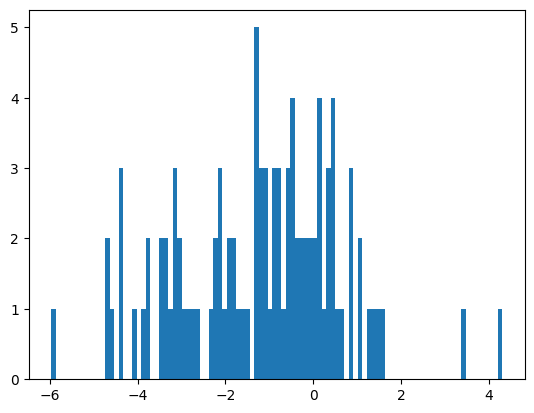

In [ ]:
plt.hist(activation_diff_iterations[:,42,3117], bins=100)
plt.show()

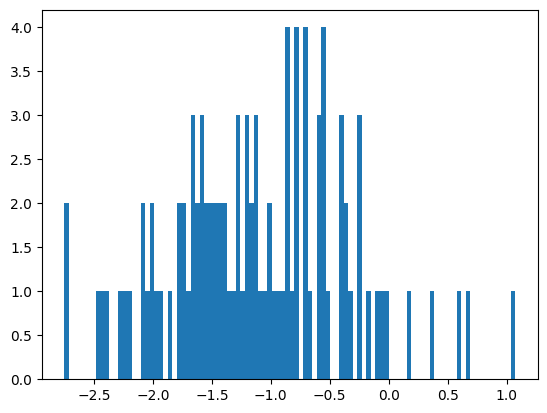

In [ ]:
plt.hist(activation_diff_iterations[:,44,4645], bins=100)
plt.show()

In [ ]:
activation_diff_iterations[0,:,:]

array([[-0.00177695, -0.0091704 , -0.05743188, ...,  0.04021569,
         0.00688269, -0.00825226],
       [-0.00412554, -0.01129024,  0.01258003, ...,  0.00506348,
        -0.01089736,  0.0023867 ],
       [-0.01050314,  0.01808189, -0.00434136, ...,  0.01106161,
         0.00418009,  0.00226187],
       ...,
       [ 0.19759855,  0.15211166,  0.05848874, ..., -0.00512991,
         0.01584215, -0.00741375],
       [-0.06034151, -0.1098424 , -0.00509805, ...,  0.20497073,
         0.16849506, -0.05574133],
       [ 0.04092622,  0.06116109, -0.00727563, ..., -0.2418837 ,
         0.04558089, -0.21082029]])

In [ ]:
activation_diff_iterations[30,:,:]

array([[-2.68102959e-02, -1.80679485e-02,  2.43434310e-02, ...,
        -1.40197426e-02,  2.17492804e-02,  2.43462864e-02],
       [ 1.20663103e-02, -1.98340602e-02, -1.13954023e-03, ...,
        -2.36729532e-02,  4.04362679e-02,  3.03445607e-02],
       [-9.06670839e-03, -2.38214433e-03,  6.46883249e-03, ...,
         3.23056430e-03, -1.28257088e-05,  1.06135644e-02],
       ...,
       [ 1.62978753e-01, -1.99711934e-01, -5.98343043e-03, ...,
         7.94281997e-03, -5.51636629e-02, -7.00013526e-03],
       [-9.92269069e-02, -9.35315341e-03,  1.42859593e-02, ...,
        -5.40394820e-02,  4.24104780e-02, -2.58448254e-02],
       [-2.06756592e-02, -2.74828076e-03,  2.45527811e-02, ...,
         1.15482509e-02,  2.01411545e-03, -2.11153001e-01]])